# Feature Selection and Model calibration by LASSO regression for Soil Organic Carbon (SOC)

# Table of contents
1. [READ DATA](#read)
2. [PREPROCESSING](#prep)
3. [LASSO](#lasso)
4. [COEFFS](#coefs)
5. [FEATURE SELECTION](#feat)
6. [BAND CALCULATION](#band)
7. [MODEL CALIBRATION](#model)
8. [VISUALIZATION](#visual)

In [1]:
# Import necessary libraries


import pandas                  as     pd

import numpy                   as     np

from sklearn.pipeline          import Pipeline

from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection   import GridSearchCV, KFold, 
LeaveOneGroupOut, cross_val_predict, cross_val_score, cross_validate, ShuffleSplit

from sklearn.metrics           import r2_score, mean_squared_error

from sklearn.linear_model      import Lasso

from sklearn.preprocessing     import StandardScaler

from matplotlib.lines          import Line2D

import matplotlib.pyplot       as     plt
%matplotlib inline


import warnings # supress warnings
warnings.filterwarnings('ignore')

## 1. READ DATA <a name="read"></a>

In [2]:
# To be able to select the most informative features, the collected spectrum dataset
# is seperated into a test set that contains 12 samples from each depth 
# (0-15, 15-30, 30-60, 60-90 cm) and the rest of the samples are collected as train set.
# This decision was made after trying to select features without splitting the dataset
# and use of several models like Ridge regression, Elastic Net, random Forest, Feature 
# Elimination and Cross validation. None of these models were able to extract the features 
# for our # study purpose.

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

cols = train.columns.tolist()

features = [x for x in cols if "WL_" in x]
outcome = 'OC'

X_train = train[features]
y_train = train[outcome]

X_test = test[features]
y_test = test[outcome]

## 2. PREPROCESSING <a name="prep"></a>

In [3]:
# It is really important to scale the data before feature selection or model performance.
# The standardScaler rescales each input by subtracting its average value 
# and dividing it by the standard deviation, effectively centering the distribution to 
# attain a mean of zero and a standard deviation of one.

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 3. LASSO <a name="lasso"></a>

In [4]:

# Create a Lasso model
lasso = Lasso()

# Define a range of alpha values to search
alphas = [0.0001, 0.0004, 0.001, 0.01, 0.1, 1.0]

# Create a parameter grid to search for the best alpha
param_grid = {'alpha': alphas}

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_scaled)
X_test_scaled = scaler.transform(X_test_scaled)

# Perform GridSearch to find the best alpha value
grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train_scaled, y_train)

# Get the best alpha value
best_alpha = grid_search.best_params_['alpha']

# Train a Lasso model with the best alpha
lasso = Lasso(alpha=best_alpha)
lasso.fit(X_train_scaled, y_train)

# Evaluate the model on the test set
score = lasso.score(X_test_scaled, y_test)
print("Best Model Score on All Features:", score)


Best Model Score on All Features: 0.6903710039640958


In [5]:
best_alpha

0.0004

In [6]:
# Make predictions on the test set
y_prediction = lasso.predict(X_test_scaled)

# Calculate MSE
mse = mean_squared_error(y_test, y_prediction)
# Calculate RMSE
rmse = np.sqrt(mse)

print("MSE:", mse)
print("RMSE:", rmse)

MSE: 0.18771257884676693
RMSE: 0.4332580972662449


## 4. COEFFICIENTS <a name="coefs"></a>

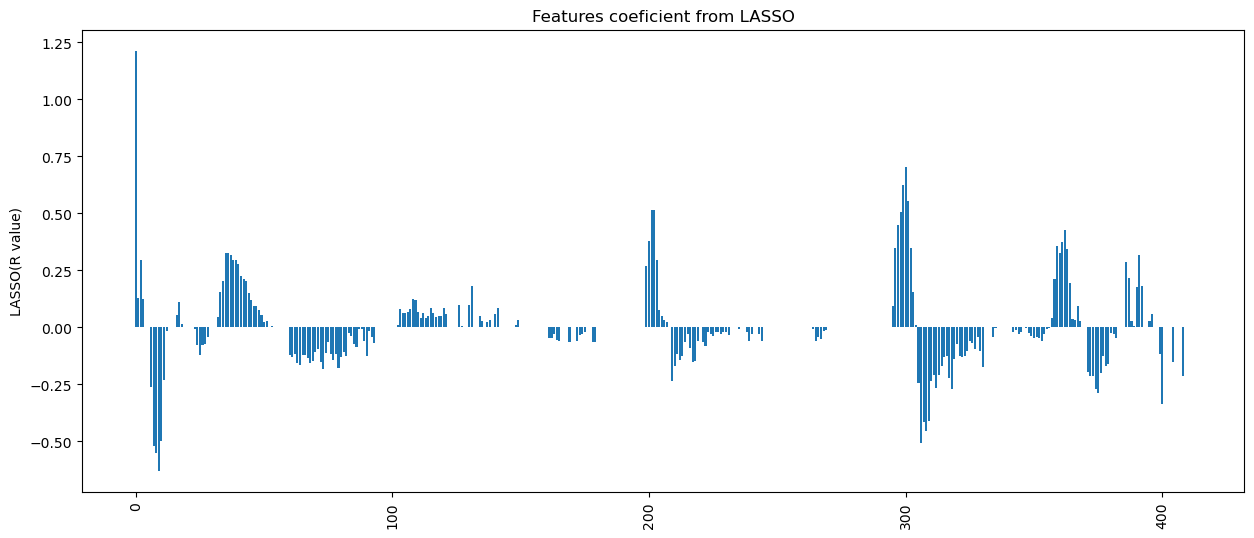

In [7]:
# Get the coefficiats of features to be able to select the most important ones

features_num = [int(x.replace("WL_","")) for x in features]

lasso_coef = lasso.coef_
plt.figure(figsize=(15,6))
plt.bar(range(len(features_num)),lasso_coef)
plt.xticks(rotation = 90, fontsize = 10)
plt.ylabel("LASSO(R value)")
plt.title("Features coeficient from LASSO");

Legend (Wavelength):`0: 393`, `100: 893`, `200: 1393`, `300: 1893`, `400: 2393`

In [8]:
print(features[300],": ",lasso_coef[300])

WL_1893 :  0.7044809783431526


In [9]:
print(features[0],": ",lasso_coef[0]) 

WL_393 :  1.2138247539892757


In [10]:
print(features[306],": ",lasso_coef[306])

WL_1923 :  -0.5087268548883263


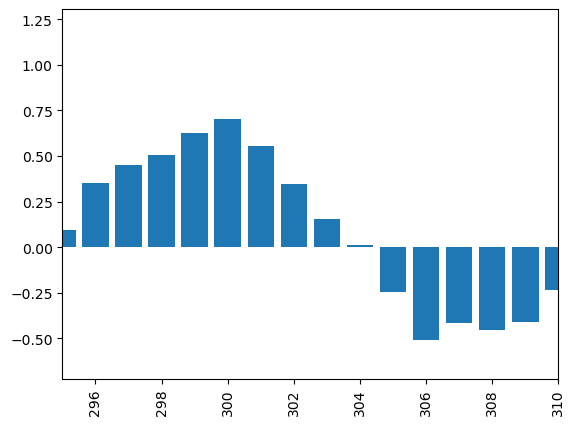

In [11]:
# Zoom in

plt.bar(range(len(features_num)),lasso_coef)
plt.xticks(rotation = 90, fontsize = 10)
plt.xlim(295,310);

## 5. FEATURE SELECTION <a name="feat"></a>

In [12]:
# Get the indices of the features sorted by the absolute coefficient values in descending order
sorted_indices = np.argsort(np.abs(lasso_coef))[::-1]
# Get the feature names corresponding to the sorted indices
sorted_features = np.array(features)[sorted_indices]

# Select the top features with the highest coefficients
top_features = sorted_features[:30]  # Select the top 30 features

# Print the selected top features
print("Top Features:")
for feature in top_features:
    print(feature)


Top Features:
WL_393
WL_1893
WL_438
WL_1888
WL_1898
WL_433
WL_428
WL_1403
WL_1398
WL_1923
WL_1883
WL_443
WL_1933
WL_1878
WL_2203
WL_1928
WL_1938
WL_1393
WL_2198
WL_2188
WL_1873
WL_1903
WL_2208
WL_2393
WL_573
WL_2193
WL_568
WL_578
WL_2348
WL_583


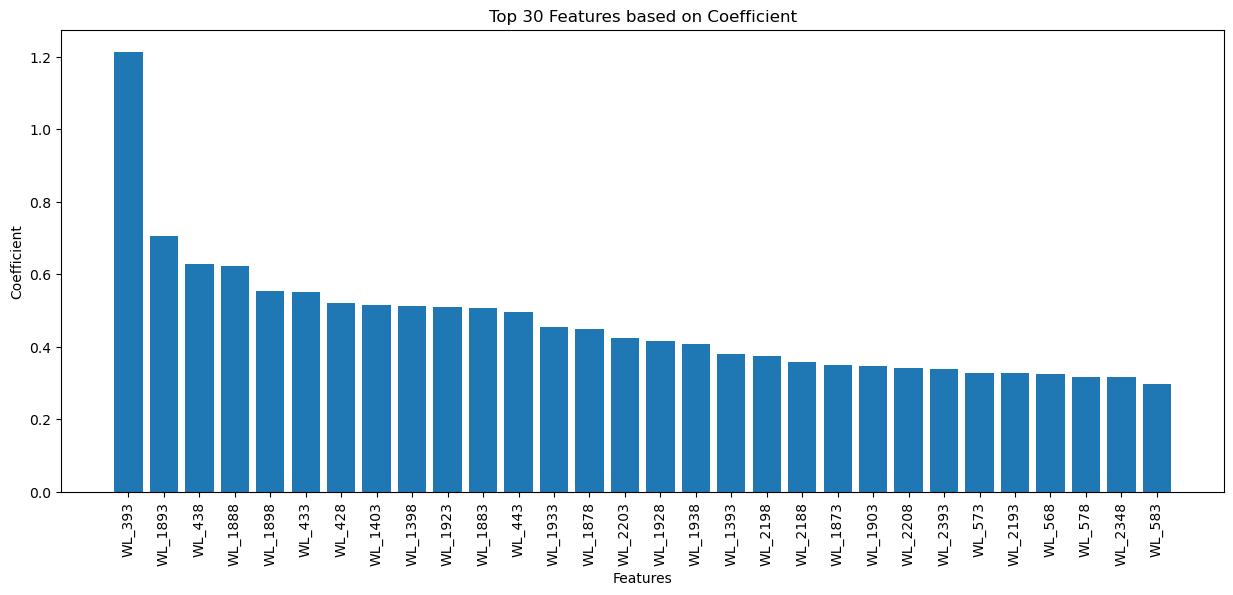

In [13]:
# Plot the top 30 features by their coefficient values
plt.figure(figsize=(15, 6))
plt.bar(range(len(top_features)), [np.abs(lasso_coef[features.index(feat)]) for feat in top_features])
plt.xticks(range(len(top_features)), top_features, rotation=90, fontsize=10)
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.title('Top 30 Features based on Coefficient')
plt.show()

### Evaluate the model on selected features

In [14]:
# Select the top 30 features
top_features = sorted_features[:30]

# Filter the train and test datasets based on the top features
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

# Initialize and train the Lasso model on the selected features
lasso_selected = Lasso(alpha=0.00001)
lasso_selected.fit(X_train_selected, y_train)

# Evaluate the model on the test set
score = lasso_selected.score(X_test_selected, y_test)
print("Model Score on Selected Features:", score)


Model Score on Selected Features: 0.589414417059368


In [15]:
# Make predictions on the test set
y_pred = lasso_selected.predict(X_test_selected)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
# Calculate RMSE
rmse = np.sqrt(mse)


print("MSE:", mse)
print("RMSE:", rmse)

MSE: 0.24891750965775813
RMSE: 0.49891633532863816


Both positive and negative coefficients are important when interpreting the results of LASSO regression for feature selection. Here's why:

1. **Positive Coefficients:** Features with positive coefficients indicate a positive relationship with the target variable. This means that as the feature value increases, the predicted outcome also tends to increase. Positive coefficients suggest that these features are positively contributing to the prediction of the target variable.

2. **Negative Coefficients:** Features with negative coefficients indicate a negative relationship with the target variable. This means that as the feature value increases, the predicted outcome tends to decrease. Negative coefficients suggest that these features are negatively impacting the prediction of the target variable.

LASSO regression, with its regularization parameter, aims to shrink some coefficients to exactly zero. This helps in feature selection by effectively eliminating certain features from the model. Features with non-zero coefficients after LASSO regularization are considered to be important predictors.

In practice, whether a positive or negative coefficient is important depends on the context of your problem and your domain knowledge. Some features with negative coefficients might be just as important as those with positive coefficients. For example, in a medical context, a negative coefficient for a certain treatment might indicate that the treatment has a positive effect on reducing a certain health condition.

When selecting features based on LASSO coefficients, consider both positive and negative coefficients. Features with large magnitude coefficients (positive or negative) tend to have a greater impact on the model's predictions. However, do keep in mind that the magnitude of the coefficients can also be affected by the scale of the features, so it's a good practice to standardize the features (as you've done) before running LASSO.

In summary, both positive and negative coefficients are important for a comprehensive understanding of feature importance in LASSO regression, and you should consider both when making decisions about feature selection.

## 6. BAND CALCULATION <a name="band"></a>

2Band and 3Band calculations to generate more datasets from selected features to be able to have better predictions, and to compare the result from different regressions. Steps to take:

1. save selected features from each regressor into a dataframe.
2. Transform rows and columns
3. Do the calculations
4. Save result into a dataframe.

We selected 30 features and as a result:


For 2band we should have a shape of 151*435 (30!/2!(30-2)!)


For 3band should have a shape of 151*4060   (30!/3!(30-3)!)


In [16]:
# Create a new dataset using the selected common features
new_df = pd.read_csv("lasso_selected features.csv")

# Print the shape of the new dataset
print(new_df.shape)

# Print the head of the new dataset
print(new_df.head())

(151, 30)
     WL_393    WL_428    WL_433    WL_438    WL_443    WL_568    WL_573  \
0  0.106475  0.117054  0.119399  0.121848  0.124280  0.190006  0.192772   
1  0.111310  0.123301  0.125900  0.128584  0.131213  0.200282  0.203254   
2  0.112192  0.123701  0.126138  0.128655  0.131141  0.196493  0.199254   
3  0.116133  0.126616  0.128866  0.131245  0.133604  0.197685  0.200379   
4  0.101300  0.113609  0.116170  0.118847  0.121432  0.187567  0.190364   

     WL_578    WL_583   WL_1393  ...   WL_1928   WL_1933   WL_1938   WL_2188  \
0  0.195434  0.198044  0.405131  ...  0.409004  0.410331  0.411923  0.430756   
1  0.206089  0.208841  0.413217  ...  0.415453  0.417057  0.418849  0.441208   
2  0.201892  0.204470  0.412068  ...  0.415991  0.417300  0.418860  0.441200   
3  0.202967  0.205502  0.412572  ...  0.410954  0.412457  0.414235  0.433637   
4  0.193021  0.195587  0.396260  ...  0.396063  0.397695  0.399506  0.417640   

    WL_2193   WL_2198   WL_2203   WL_2208   WL_2348   WL_2

In [17]:
df= pd.read_csv("dataset.csv") # to add soil properties to generated data

In [18]:
rt= new_df
rt

,WL_393,WL_428,WL_433,WL_438,WL_443,WL_568,WL_573,WL_578,WL_583,WL_1393,...,WL_1928,WL_1933,WL_1938,WL_2188,WL_2193,WL_2198,WL_2203,WL_2208,WL_2348,WL_2393
0,0.106475,0.117054,0.119399,0.121848,0.124280,0.190006,0.192772,0.195434,0.198044,0.405131,...,0.409004,0.410331,0.411923,0.430756,0.429119,0.427840,0.427593,0.428493,0.419346,0.419851
1,0.111310,0.123301,0.125900,0.128584,0.131213,0.200282,0.203254,0.206089,0.208841,0.413217,...,0.415453,0.417057,0.418849,0.441208,0.439162,0.437527,0.436886,0.437565,0.430360,0.431824
2,0.112192,0.123701,0.126138,0.128655,0.131141,0.196493,0.199254,0.201892,0.204470,0.412068,...,0.415991,0.417300,0.418860,0.441200,0.439618,0.438474,0.438274,0.439093,0.433202,0.436569
3,0.116133,0.126616,0.128866,0.131245,0.133604,0.197685,0.200379,0.202967,0.205502,0.412572,...,0.410954,0.412457,0.414235,0.433637,0.431750,0.429984,0.429326,0.430119,0.418555,0.416476
4,0.101300,0.113609,0.116170,0.118847,0.121432,0.187567,0.190364,0.193021,0.195587,0.396260,...,0.396063,0.397695,0.399506,0.417640,0.415345,0.413346,0.412506,0.413098,0.403468,0.401698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,0.079160,0.094772,0.098665,0.102776,0.106776,0.258750,0.267540,0.275393,0.282332,0.509797,...,0.458883,0.465472,0.471233,0.512319,0.504585,0.497444,0.493994,0.495595,0.477922,0.456343
147,0.170958,0.199924,0.204527,0.209027,0.213423,0.307609,0.310518,0.313207,0.315773,0.562986,...,0.505728,0.509461,0.513054,0.570526,0.566778,0.563325,0.561731,0.562062,0.520486,0.514257
148,0.149453,0.173955,0.179044,0.184358,0.189519,0.326435,0.332508,0.338210,0.343590,0.567402,...,0.562447,0.564346,0.566157,0.577496,0.573259,0.569473,0.567992,0.569075,0.561689,0.558143
149,0.185349,0.217726,0.223485,0.229198,0.234745,0.347442,0.351478,0.355212,0.358719,0.578916,...,0.568803,0.570979,0.573035,0.588713,0.584444,0.580649,0.579246,0.580663,0.572859,0.567967


In [19]:
from itertools import combinations
from math import comb
comb(30,2)   # Number of generated features from 30 selected features:
             #For triple-band:4060 , for dual-band:435 

435

## Dual-band

### NDI

In [20]:
colnames=rt.columns.to_list()
colnames

['WL_393',
 'WL_428',
 'WL_433',
 'WL_438',
 'WL_443',
 'WL_568',
 'WL_573',
 'WL_578',
 'WL_583',
 'WL_1393',
 'WL_1398',
 'WL_1403',
 'WL_1873',
 'WL_1878',
 'WL_1883',
 'WL_1888',
 'WL_1893',
 'WL_1898',
 'WL_1903',
 'WL_1923',
 'WL_1928',
 'WL_1933',
 'WL_1938',
 'WL_2188',
 'WL_2193',
 'WL_2198',
 'WL_2203',
 'WL_2208',
 'WL_2348',
 'WL_2393']

In [21]:
combilist=[i for i in combinations(colnames,2)]

In [22]:
len(combilist)

435

In [23]:
def foo(x,y):
    return (rt[y]-rt[x]).abs()/(rt[y]+rt[x]).abs()

In [24]:
NDI= [foo(elem[0],elem[1]) for elem in combilist]
len(NDI)

435

In [25]:
res=pd.DataFrame()

for elem in combilist:
    x,y = elem
    res[f'{x}_{y}']=foo(x,y)

In [26]:
# To add OC to new dataframes
res['OC']= df['OC']

In [27]:
res

,WL_393_WL_428,WL_393_WL_433,WL_393_WL_438,WL_393_WL_443,WL_393_WL_568,WL_393_WL_573,WL_393_WL_578,WL_393_WL_583,WL_393_WL_1393,WL_393_WL_1398,...,WL_2198_WL_2208,WL_2198_WL_2348,WL_2198_WL_2393,WL_2203_WL_2208,WL_2203_WL_2348,WL_2203_WL_2393,WL_2208_WL_2348,WL_2208_WL_2393,WL_2348_WL_2393,OC
0,0.047330,0.057218,0.067332,0.077163,0.281744,0.288382,0.294657,0.300701,0.583763,0.582828,...,0.000763,0.010025,0.009425,0.001051,0.009737,0.009136,0.010788,0.010187,0.000601,1.5
1,0.051109,0.061504,0.072006,0.082063,0.285538,0.292287,0.298609,0.304639,0.575578,0.574276,...,0.000043,0.008258,0.006560,0.000776,0.007526,0.005828,0.008302,0.006604,0.001698,1.5
2,0.048793,0.058519,0.068355,0.077874,0.273100,0.279543,0.285593,0.291410,0.572000,0.570970,...,0.000706,0.006048,0.002178,0.000933,0.005821,0.001950,0.006754,0.002883,0.003871,1.2
3,0.043185,0.051972,0.061087,0.069958,0.259871,0.266170,0.272122,0.277857,0.560688,0.559602,...,0.000157,0.013470,0.015959,0.000923,0.012704,0.015193,0.013626,0.016116,0.002490,1.7
4,0.057278,0.068378,0.079705,0.090390,0.298640,0.305366,0.311638,0.317587,0.592814,0.591517,...,0.000301,0.012094,0.014291,0.000716,0.011077,0.013274,0.011793,0.013990,0.002197,1.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,0.089762,0.109689,0.129805,0.148524,0.531473,0.543353,0.553467,0.562038,0.731186,0.727699,...,0.001862,0.020015,0.043092,0.001617,0.016537,0.039619,0.018154,0.041233,0.023097,1.1
147,0.078100,0.089401,0.100185,0.110476,0.285541,0.289858,0.293802,0.297525,0.534138,0.531290,...,0.001123,0.039526,0.045535,0.000294,0.038112,0.044122,0.038405,0.044415,0.006020,1.3
148,0.075762,0.090079,0.104565,0.118199,0.371899,0.379814,0.387065,0.393753,0.583032,0.581481,...,0.000350,0.006881,0.010048,0.000952,0.005579,0.008746,0.006531,0.009697,0.003166,0.3
149,0.080325,0.093279,0.105776,0.117584,0.304233,0.309465,0.314235,0.318655,0.514961,0.513200,...,0.000011,0.006754,0.011041,0.001222,0.005544,0.009831,0.006765,0.011052,0.004287,1.0


In [28]:
res.to_csv('NDI_OC_lasso.csv',index=False)

### SRI

In [29]:
def SRoo(x,y):
    return (rt[y])/(rt[x])

In [30]:
SRI= [SRoo(elem[0],elem[1]) for elem in combilist]
len(SRI)

435

In [31]:
sr=pd.DataFrame()

for elem in combilist:
    x,y = elem
    sr[f'{x}_{y}']=SRoo(x,y)

In [32]:
sr['OC']= df['OC']

In [33]:
sr

,WL_393_WL_428,WL_393_WL_433,WL_393_WL_438,WL_393_WL_443,WL_393_WL_568,WL_393_WL_573,WL_393_WL_578,WL_393_WL_583,WL_393_WL_1393,WL_393_WL_1398,...,WL_2198_WL_2208,WL_2198_WL_2348,WL_2198_WL_2393,WL_2203_WL_2208,WL_2203_WL_2348,WL_2203_WL_2393,WL_2208_WL_2348,WL_2208_WL_2393,WL_2348_WL_2393,OC
0,1.099363,1.121381,1.144385,1.167230,1.784522,1.810496,1.835500,1.860006,3.804950,3.794183,...,1.001527,0.980148,0.981327,1.002104,0.980713,0.981893,0.978654,0.979831,1.001203,1.5
1,1.107724,1.131070,1.155187,1.178799,1.799311,1.826006,1.851478,1.876202,3.712291,3.697880,...,1.000087,0.983619,0.986965,1.001553,0.985061,0.988412,0.983534,0.986880,1.003402,1.5
2,1.102591,1.124312,1.146741,1.168902,1.751410,1.776015,1.799525,1.822508,3.672895,3.661676,...,1.001412,0.987976,0.995654,1.001868,0.988426,0.996108,0.986583,0.994250,1.007772,1.2
3,1.090268,1.109642,1.130123,1.150442,1.702230,1.725427,1.747712,1.769535,3.552574,3.541343,...,1.000314,0.973419,0.968584,1.001848,0.974911,0.970069,0.973113,0.968280,0.995033,1.7
4,1.121516,1.146794,1.173217,1.198745,1.851602,1.879212,1.905447,1.930777,3.911758,3.896160,...,0.999399,0.976101,0.971821,1.001433,0.978088,0.973799,0.976688,0.972405,0.995615,1.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,1.197228,1.246406,1.298336,1.348863,3.268697,3.379750,3.478948,3.566608,6.440100,6.344827,...,0.996283,0.960756,0.917376,1.003240,0.967464,0.923782,0.964340,0.920799,0.954849,1.1
147,1.169433,1.196355,1.222679,1.248394,1.799320,1.816336,1.832069,1.847076,3.293117,3.267030,...,0.997757,0.923953,0.912896,1.000588,0.926575,0.915485,0.926030,0.914948,0.988032,1.3
148,1.163946,1.197994,1.233550,1.268085,2.184202,2.224839,2.262991,2.298985,3.796531,3.778758,...,0.999300,0.986332,0.980105,1.001905,0.988903,0.982660,0.987022,0.980791,0.993687,0.3
149,1.174682,1.205751,1.236576,1.266503,1.874527,1.896304,1.916449,1.935372,3.123383,3.108465,...,1.000023,0.986582,0.978159,1.002446,0.988973,0.980529,0.986560,0.978137,0.991462,1.0


In [34]:
sr.to_csv('SRI_OC_lasso.csv',index=False)

# Triple-band

### TBI_1

In [35]:
combilist_tbi=[i for i in combinations(colnames,3)]

In [36]:
def Noo(x,y,z):
    return (rt[x]*rt[y])/(rt[z])

In [37]:
TBI= [Noo(elem[0],elem[1],elem[2]) for elem in combilist_tbi]
len(TBI)

4060

In [38]:
tb=pd.DataFrame()

for elem in combilist_tbi:
    x,y,z = elem
    tb[f'{x}_{y}_{z}']=Noo(x,y,z)
    

In [39]:
tb['OC']= df['OC']

In [40]:
tb

,WL_393_WL_428_WL_433,WL_393_WL_428_WL_438,WL_393_WL_428_WL_443,WL_393_WL_428_WL_568,WL_393_WL_428_WL_573,WL_393_WL_428_WL_578,WL_393_WL_428_WL_583,WL_393_WL_428_WL_1393,WL_393_WL_428_WL_1398,WL_393_WL_428_WL_1403,...,WL_2198_WL_2203_WL_2348,WL_2198_WL_2203_WL_2393,WL_2198_WL_2208_WL_2348,WL_2198_WL_2208_WL_2393,WL_2198_WL_2348_WL_2393,WL_2203_WL_2208_WL_2348,WL_2203_WL_2208_WL_2393,WL_2203_WL_2348_WL_2393,WL_2208_WL_2348_WL_2393,OC
0,0.104384,0.102286,0.100284,0.065594,0.064653,0.063772,0.062932,0.030764,0.030851,0.030925,...,0.436254,0.435730,0.437171,0.436646,0.427326,0.436920,0.436395,0.427080,0.427978,1.5
1,0.109013,0.106737,0.104599,0.068527,0.067525,0.066596,0.065719,0.033214,0.033344,0.033459,...,0.444162,0.442657,0.444852,0.443344,0.436044,0.444201,0.442695,0.435405,0.436081,1.5
2,0.110024,0.107872,0.105827,0.070630,0.069651,0.068741,0.067874,0.033680,0.033783,0.033878,...,0.443608,0.440187,0.444437,0.441010,0.435093,0.444235,0.440809,0.434894,0.435707,1.2
3,0.114106,0.112038,0.110059,0.074383,0.073383,0.072447,0.071553,0.035641,0.035754,0.035849,...,0.441049,0.443251,0.441864,0.444070,0.432131,0.441188,0.443390,0.431469,0.432266,1.7
4,0.099067,0.096836,0.094773,0.061357,0.060456,0.059623,0.058841,0.029043,0.029159,0.029254,...,0.422606,0.424468,0.423212,0.425076,0.415167,0.422352,0.424212,0.414323,0.414917,1.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,0.076037,0.072995,0.070261,0.028994,0.028041,0.027242,0.026572,0.014716,0.014937,0.015143,...,0.514173,0.538486,0.515839,0.540231,0.520966,0.512261,0.536484,0.517353,0.519029,1.1
147,0.167111,0.163513,0.160145,0.111111,0.110070,0.109125,0.108238,0.060710,0.061194,0.061620,...,0.607965,0.615329,0.608322,0.615691,0.570148,0.606602,0.613949,0.568536,0.568870,1.3
148,0.145205,0.141020,0.137179,0.079642,0.078188,0.076870,0.075666,0.045819,0.046035,0.046201,...,0.575864,0.579522,0.576961,0.580626,0.573091,0.575461,0.579116,0.571601,0.572690,0.3
149,0.180573,0.176072,0.171911,0.116150,0.114816,0.113609,0.112498,0.069708,0.070043,0.070306,...,0.587123,0.592180,0.588560,0.593628,0.585650,0.587137,0.592193,0.584234,0.585663,1.0


In [41]:
tb.to_csv('TBI_1_OC_lasso.csv',index=False)

### TBI_2

In [42]:
def tbi2(x,y,z):
    return (rt[x]-rt[y]).abs()/(rt[x]+rt[z])

In [43]:
TB2= [tbi2(elem[0],elem[1],elem[2]) for elem in combilist_tbi]
len(TB2)

4060

In [44]:
tb_2=pd.DataFrame()

for elem in combilist_tbi:
    x,y,z = elem
    tb_2[f'{x}_{y}_{z}']=tbi2(x,y,z)
    

In [45]:
tb_2['OC']= df['OC']

In [46]:
tb_2

,WL_393_WL_428_WL_433,WL_393_WL_428_WL_438,WL_393_WL_428_WL_443,WL_393_WL_428_WL_568,WL_393_WL_428_WL_573,WL_393_WL_428_WL_578,WL_393_WL_428_WL_583,WL_393_WL_428_WL_1393,WL_393_WL_428_WL_1398,WL_393_WL_428_WL_1403,...,WL_2198_WL_2203_WL_2348,WL_2198_WL_2203_WL_2393,WL_2198_WL_2208_WL_2348,WL_2198_WL_2208_WL_2393,WL_2198_WL_2348_WL_2393,WL_2203_WL_2208_WL_2348,WL_2203_WL_2208_WL_2393,WL_2203_WL_2348_WL_2393,WL_2208_WL_2348_WL_2393,OC
0,0.046839,0.046336,0.045848,0.035684,0.035354,0.035042,0.034742,0.020679,0.020726,0.020765,...,0.000291,0.000291,0.000771,0.000771,0.010019,0.001062,0.001062,0.009732,0.010782,1.5
1,0.050549,0.049983,0.049442,0.038482,0.038119,0.037778,0.037453,0.022860,0.022930,0.022993,...,0.000738,0.000737,0.000044,0.000044,0.008244,0.000782,0.000781,0.007513,0.008288,1.5
2,0.048294,0.047789,0.047301,0.037287,0.036956,0.036646,0.036348,0.021955,0.022007,0.022056,...,0.000229,0.000228,0.000710,0.000708,0.006025,0.000940,0.000936,0.005798,0.006728,1.2
3,0.042788,0.042377,0.041976,0.033405,0.033121,0.032852,0.032593,0.019828,0.019877,0.019918,...,0.000776,0.000778,0.000159,0.000159,0.013503,0.000936,0.000938,0.012735,0.013660,1.7
4,0.056603,0.055915,0.055266,0.042613,0.042205,0.041823,0.041462,0.024740,0.024819,0.024883,...,0.001028,0.001030,0.000304,0.000305,0.012120,0.000725,0.000726,0.011101,0.011819,1.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,0.087797,0.085813,0.083967,0.046203,0.045032,0.044034,0.043189,0.026509,0.026853,0.027172,...,0.003537,0.003617,0.001896,0.001939,0.020468,0.001647,0.001684,0.016912,0.018565,1.1
147,0.077143,0.076229,0.075357,0.060527,0.060161,0.059827,0.059511,0.039466,0.039707,0.039918,...,0.001470,0.001479,0.001166,0.001172,0.039755,0.000305,0.000307,0.038333,0.038628,1.3
148,0.074589,0.073401,0.072284,0.051487,0.050838,0.050244,0.049696,0.034180,0.034307,0.034405,...,0.001309,0.001313,0.000352,0.000353,0.006903,0.000958,0.000961,0.005597,0.006552,0.3
149,0.079194,0.078102,0.077071,0.060769,0.060312,0.059895,0.059509,0.042364,0.042518,0.042638,...,0.001217,0.001222,0.000011,0.000011,0.006783,0.001230,0.001235,0.005568,0.006794,1.0


In [51]:
tb_2.to_csv('TBI_2_OC_lasso.csv',index=False)

 ## 7. MODEL CALIBRATION <a name="model"></a>

In [52]:
df = pd.read_csv("TBI_2_OC_lasso.csv")

cols = df.columns.tolist()
features = [x for x in cols if "WL_" in x]
outcome = 'OC'

X = df[features]
y = df[outcome]

In [53]:
# Define the outer and inner cross-validation strategies
outer_cv = KFold(n_splits=10, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Create the pipeline with Lasso regression and hyperparameter tuning
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Lasso())
])

grid_search = GridSearchCV(
    estimator=pipeline, param_grid={'alpha': [0.00001, 0.0001, 0.0004, 0.001, 0.01, 0.1, 1, 10]},
    cv=inner_cv, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the GridSearchCV object on the data
grid_search.fit(X, y)
    
# Get the best hyperparameters
best_alpha = grid_search.best_params_['regressor__alpha']
    
# Set the best hyperparameters in pipeline
pipeline.set_params(regressor__alpha=best_alpha)
    
    
# Perform nested cross-validation for R2 values
nested_r2_scores = cross_val_score(pipeline, X=X, y=y, cv=outer_cv, scoring='r2')

# Calculate mean and standard deviation of nested R2 scores
mean_nested_r2 = nested_r2_scores.mean()
std_nested_r2 = nested_r2_scores.std()

print("Mean Nested R2:", mean_nested_r2)
print("Std Nested R2:", std_nested_r2)

Mean Nested R2: 0.25440596516635966
Std Nested R2: 0.24953756061296026


In [54]:
# The inner loop was used to perform predictions while outter loop was used for 
#hyperparameter tuning. Predictions are made according to mean R2

y_pred = cross_val_predict(estimator=pipeline, X=X, y=y, cv=outer_cv, n_jobs=-1)

In [55]:
# Since the number of samples were limited (151 from all 4 depths), Nested cross validation
# was used to perform predictions for all the samples without a need for validation set.

len(y_pred)

151

In [56]:
# Assessing predictive metrics for predictions

y = y.values.flatten()
y_pred = y_pred.flatten()


mse = mean_squared_error(y, y_pred)
rmse = mean_squared_error(y, y_pred, squared=False)
r2 = r2_score(y, y_pred)


# Calculate Mean Absolute Error (MAE)
mae = np.mean(np.abs(y - y_pred))

# Calculate Interquartile Range (IQR) of the true values
from scipy import stats
iqr = stats.iqr(y)

# Calculate RPIQ
rpiq = mae / iqr



# Print the evaluation metrics
print("Mean Squared Error:", mse)
print(f"RPIQ: {rpiq}")
print(f"Mean Absolute Error (MAE): {mae}")
print("Root Mean Squared Error:", rmse)
print("R-squared Score:", r2)

Mean Squared Error: 0.3473726995896972
RPIQ: 0.5807128588046903
Mean Absolute Error (MAE): 0.43553464410351767
Root Mean Squared Error: 0.5893833214383464
R-squared Score: 0.42553519970635134


 ## 8. VISUALIZATION <a name="visual"></a>

In [57]:
# Define the depth values for each group
depth_values = np.repeat([7.5, 22.5, 45, 75], [38, 38, 38, 37])

# Add a new column 'Modified_Depth' to DataFrame
df['Modified_Depth'] = depth_values

# Example data with modified depths and predicted values
depths = df['Modified_Depth']
y_pred = np.random.rand(len(depths)) 
y = np.random.rand(len(depths))  

# Create a dictionary to map depths to colors and marker styles
depth_properties = {
    7.5: {'color': 'black', 'marker': 's'},
    22.5: {'color': 'black', 'marker': '^'},
    45: {'color': 'black', 'marker': 'o'},
    75: {'color': 'black', 'marker': 'D'}
}  # You can customize colors and markers as needed

plt.figure(figsize=(10, 8))

legend_handles = []  # Create a list to store legend handles

for depth, y_pred_value, obs_value in zip(depths, y_pred, y):
    properties = depth_properties[float(depth)]  # Convert depth to float to handle floating-point keys
    color = properties['color']
    marker = properties['marker']
    
    plt.scatter(obs_value, y_pred_value, alpha=0.7, marker=marker, color=color)
    
    # Check if this depth has been added to the legend
    if depth not in [handle.get_label() for handle in legend_handles]:
        legend_handles.append(Line2D([0], [0], marker=marker, color='white', label=f'Depth {depth}', markersize=8, markerfacecolor=color))

# Create custom legend entries with only the first value's color and symbol for each depth
unique_depths = set(depths)
unique_handles = []
for depth in unique_depths:
    matching_handles = [handle for handle in legend_handles if handle.get_label() == f'Depth {depth}']
    if matching_handles:
        unique_handles.append(matching_handles[0])

# Annotate metrics on the plot
plt.text(0.05, 0.92, f'R^2: {r2:.2f}', transform=plt.gca().transAxes)
plt.text(0.05, 0.94, f'RMSE: {rmse:.2f}', transform=plt.gca().transAxes)


plt.plot([min(y), max(y)], [min(y), max(y)], color='k', linestyle='--', label=f'Perfect Prediction\nR2={r2:.2f} RMSE={rmse:.2f}')
plt.xlabel('Measured SOC (g.kg-1)')
plt.ylabel('Predicted SOC (g.kg-1)')
plt.title('Measured Vs. Predicted values of Soil Organic Carbon')
plt.grid(True)

# Move the legend outside the plot to the upper right
plt.legend(handles=unique_handles, bbox_to_anchor=(1.05, 1), loc='lower left')

plt.show()

1

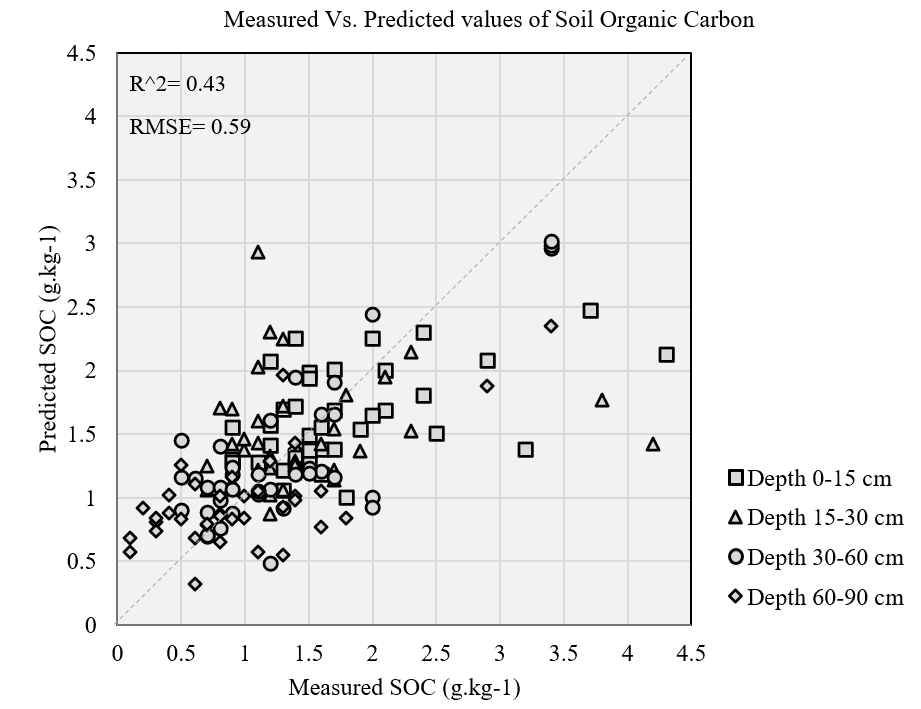

Same procedure was performed for all 7 soil properties in all 4 depths using all the 126 datsets generated. This example is only one part of the study that shows the best performance for Soil Organic Carbon.